# Key Input Classifier (ASDF)

In [1]:
# ID: 2018116323 (undergraduate)
# NAME: DaeHeon Yoon
# File name: key_input_classifier.ipynb
# Platform: Python 3.8.10 on Windows 10
# Required Package(s): numpy, pandas

# import packages

import sys, os
sys.path.append(os.pardir)

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
from common.trainer import Trainer

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# Load data and set position name

x_names = ['L%d%c' % (i, c) for i in range(21) for c in ['x', 'y', 'z']] 
y_names = ['a', 's', 'd', 'f', 'None']

col_names = x_names + y_names

df = pd.read_csv("asdf_single_log_long.csv", names=col_names)
df.head()

,L0x,L0y,L0z,L1x,L1y,L1z,L2x,L2y,L2z,L3x,...,L19y,L19z,L20x,L20y,L20z,a,s,d,f,None
0,0.791001,0.033868,-0.000051,0.687616,0.102485,-0.040095,0.623654,0.185545,-0.108957,0.591199,...,0.437036,-0.282023,0.808288,0.486684,-0.293963,0,0,0,0,NaN
1,0.796948,0.022000,-0.000071,0.698906,0.100945,-0.030365,0.642395,0.186335,-0.095864,0.613788,...,0.421846,-0.189610,0.823863,0.451457,-0.170014,0,0,0,0,NaN
2,0.798276,0.033748,-0.000126,0.702303,0.100440,-0.040609,0.645481,0.188683,-0.114899,0.619026,...,0.426788,-0.223007,0.828177,0.463538,-0.206136,0,0,0,0,NaN
3,0.802211,0.033865,-0.000099,0.706085,0.096787,-0.038722,0.649883,0.186026,-0.110250,0.624283,...,0.426736,-0.222145,0.824583,0.463081,-0.203622,0,0,0,0,NaN
4,0.803565,0.035517,-0.000097,0.710019,0.095915,-0.036353,0.654658,0.184940,-0.108181,0.628483,...,0.427331,-0.235441,0.826368,0.466471,-0.216050,0,0,0,0,NaN


In [3]:
# Add data "None" label

y_names_origin = ['a', 's', 'd', 'f']

for row in range(len(df)):
    df['None'].iloc[row] = 1
    for value in df[y_names_origin].iloc[row]:
        if value == 1:
            df['None'].iloc[row] = 0
            break

In [4]:
# data smoothing

def gamma_smoothing(df, gamma=0.4):
    for x in x_names:
        for row in range(1, len(df)):
            df[x].iloc[row] = df[x].iloc[row-1] * (1-gamma) + df[x].iloc[row] * gamma

    return df

df = gamma_smoothing(df)

In [5]:
# data normalization

def MinMaxScaler(data):
    data_max = data.min()
    data_min = data.max()

    for i in range(len(data)):
        data[i] = (data[i] - data_min) / (data_max - data_min)
    
    return data


for column in x_names:
    df_column = df[column]
    df_column = df_column.values.reshape(-1, 1)
    df_column = MinMaxScaler(df_column)

    for row in range(len(df)):
        df[column].iloc[row] = df_column[row]

In [6]:
# x, y split

x, y = df[x_names], df[y_names]

In [7]:
# train, test split, not combine

train_test_ratio = 0.90

train_num = int(len(df) * train_test_ratio)

x_train, x_test = x[:train_num], x[train_num:]
y_train, y_test = y[:train_num], y[train_num:]


x_train_numpy = x_train.to_numpy()
x_test_numpy = x_test.to_numpy()
y_train_numpy = y_train.to_numpy()
y_test_numpy = y_test.to_numpy()

In [8]:
# mlp model

class SimpleMLP:
    def __init__(self, weight_init_std=0.01):

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(63, 32)
        self.params['b1'] = np.zeros(32)
        # self.params['W2'] = weight_init_std * \
        #                     np.random.randn(32, 16)
        # self.params['b2'] = np.zeros(16)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(32, 5)
        self.params['b3'] = np.zeros(5)


        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        # self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        # self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        # grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        # for i, key in enumerate(['Affine1', 'Affine2', 'Affine3']):
        for i, key in enumerate(['Affine1', 'Affine3']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


In [9]:
# Model Train

model = SimpleMLP()

max_epochs = 100

# trainer.py - Line 30 (FIXED)
# self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
# to
# self.iter_per_epoch = max(self.train_size // mini_batch_size, 1)

trainer = Trainer(model, x_train_numpy, y_train_numpy, x_test_numpy, y_test_numpy, 
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.002},
                  evaluate_sample_num_per_epoch=1000)

trainer.train()

904105840590747
train loss:0.2763591096077433
train loss:0.32992224778443613
train loss:0.24011993258190553
train loss:0.27891817190151824
train loss:0.38022232312406545
train loss:0.27643989112760214
train loss:0.30066941308735357
train loss:0.227432323350999
train loss:0.2551230260083955
train loss:0.4335672990181837
train loss:0.26482563506188594
train loss:0.261787806917115
train loss:0.23140631904427456
train loss:0.28192129822859546
train loss:0.22440717244557487
train loss:0.35254997894887113
train loss:0.35913972025933005
train loss:0.224982883010161
train loss:0.26478339537543233
train loss:0.1985567928639183
train loss:0.21024891436133278
train loss:0.32795669167435626
=== epoch:86, train acc:0.874, test acc:0.8134831460674158 ===
train loss:0.32526614081914396
train loss:0.37259293276993233
train loss:0.3593788191048851
train loss:0.28539444668593417
train loss:0.30779494328506174
train loss:0.172249712601284
train loss:0.28726345521363905
train loss:0.2838568923948985
train

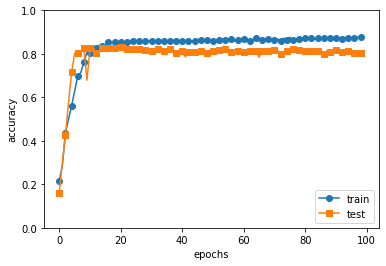

In [10]:
# Train - Test accuracy result

# 매개변수 보존
model.save_params("params.pkl")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [11]:
predict = model.predict(x_test_numpy)

size = len(y_test_numpy)

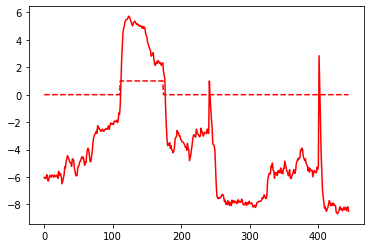

In [12]:
plt.plot(range(size), y_test_numpy[:,0], 'r--')
plt.plot(range(size), predict[:,0], 'r')

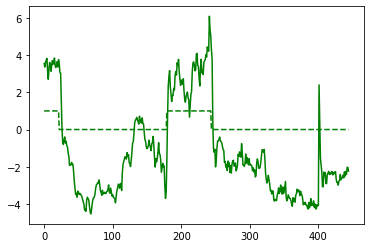

In [13]:
plt.plot(range(size), y_test_numpy[:,1], 'g--')
plt.plot(range(size), predict[:,1], 'g')

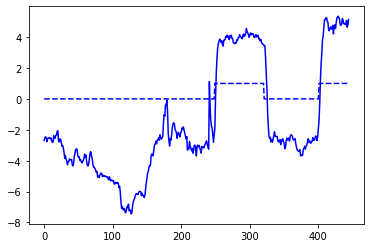

In [14]:
plt.plot(range(size), y_test_numpy[:,2], 'b--')
plt.plot(range(size), predict[:,2], 'b')

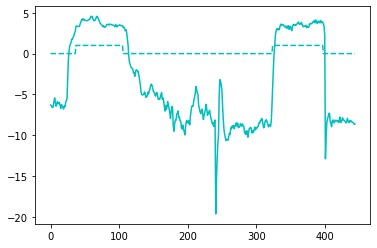

In [15]:
plt.plot(range(size), y_test_numpy[:,3], 'c--')
plt.plot(range(size), predict[:,3], 'c')

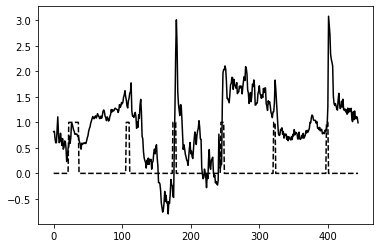

In [16]:
plt.plot(range(size), y_test_numpy[:,4], 'k--')
plt.plot(range(size), predict[:,4], 'k')

In [17]:
def up_sensitivity(data, sensitivity=3):

    data[0], data[1], data[2], data[3], data[4] = max(data[0], 0), max(data[1], 0), max(data[2], 0), \
                                                  max(data[3], 0), max(data[4], 0)

    denominator = (sensitivity * sum(data) - (sensitivity - 1) * data[4])
    
    data[0], data[1], data[2], data[3], data[4] = (
    sensitivity * data[0] / denominator,
    sensitivity * data[1] / denominator,
    sensitivity * data[2] / denominator,
    sensitivity * data[3] / denominator,
    data[4] / denominator
    )

    return data

In [18]:
# Postprocessing
predict = model.predict(x_test_numpy)

correct = 0

for row in range(size):
    predict[row] = up_sensitivity(predict[row])
    if predict[row].argmax() == y_test_numpy[row].argmax():
        correct += 1

print("Scaled score: ", correct / size)

Scaled score:  0.9056179775280899


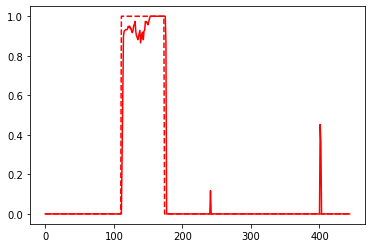

In [19]:
plt.plot(range(size), y_test_numpy[:,0], 'r--')
plt.plot(range(size), predict[:,0], 'r')

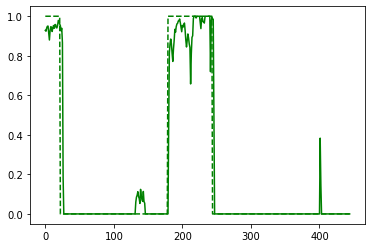

In [20]:
plt.plot(range(size), y_test_numpy[:,1], 'g--')
plt.plot(range(size), predict[:,1], 'g')

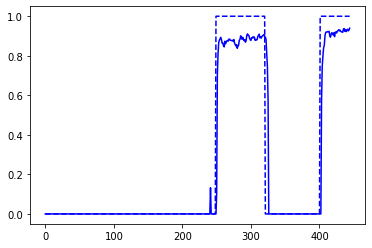

In [21]:
plt.plot(range(size), y_test_numpy[:,2], 'b--')
plt.plot(range(size), predict[:,2], 'b')

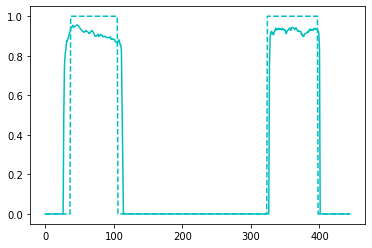

In [22]:
plt.plot(range(size), y_test_numpy[:,3], 'c--')
plt.plot(range(size), predict[:,3], 'c')

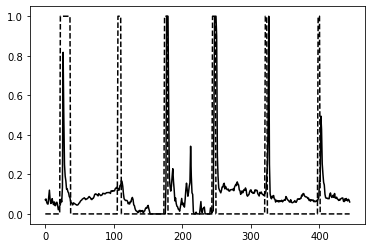

In [23]:
plt.plot(range(size), y_test_numpy[:,4], 'k--')
plt.plot(range(size), predict[:,4], 'k')